## Capacitated Vehicle Routing Problem

>**Given** A fleet of identical vehicles, with limited capacity, located at a depot; $n$ customers that require service with known demand; cost of travel between any pair of customers, or between any customer and the depot.

>**Find** A minimum-cost collection of vehicle routes, each starting and ending at the depot, such that each customer is visited by exactly one vehicle, and no vehicle visits a set of customers whose total demand exceeds the vehicle capacity.

Let $G=(V,A)$ be a directed graph with node $1$ representing the depot and $V_C=V\setminus{1}$ representing the customers.
The (positive integer) demand of customer $i \in V_C$ is denoted by $q_i$.
For any set of customer $S \subset V_C$ let $q(S)=\sum_{i \in S} q_i$.

### Two-index formulation

$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is some vehicle travels from $i$ to $j$} \\
0 \text{ otherwise}
\end{cases}
$$


$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} \\
\text{subject}& \text{ to} \\
\sum_{j \in \delta^+(i)} x_{ij} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} x_{ji} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^+(i)} x_{ij} & \ge \lceil{q(S)/Q} \rceil \;\ \forall S \subseteq V_C\\
 x_{ij} \in \{0,1\} \;\; \forall(i,j) \in A \\
\end{align}
$$

The constraints $\sum_{j \in \delta^+(i)} x_{ij}  \ge \lceil{q(S)/Q} \rceil $ are called *rounded capacity inequalities*

### Single commodity flow formulation

Define a continuous variable $f_{ij}$ for each arc $(i,j) \in A$ representing the load (flow) 
carried from $i$ to $j$. The rounded capacity inequalities can be replaced with:

$$
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} = q_i \forall i \in V_C\\
0 \le f_{ij} \le Q x_{ij}
$$

### Strengthening

$$q_j x_{ij} \le f_{ij} \le (Q-q_i) x_{ij} \;\; \forall (i,j) \in A$$

In [1]:
#!/usr/bin/env python


import networkx as nx
import gurobipy as gb
#import pygraphviz as pygv
import argparse
from argparse import ArgumentTypeError
#import pygraphviz as pygv
import os
from itertools import combinations
from IPython.display import SVG, display



In [ ]:
#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(directed='true',strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == depot:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()


def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos,fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sol.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

def DrawSubtour (x, subtour):
    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i in subtour:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true', style='filled')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sub.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()


    

In [2]:
class args:
    filename = None
    scale = 30
    capacity = 5000

In [3]:
# 
# Read the graph in the graphML format
#

args.filename = 'cvrp.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

depot = list(G.nodes())[0]

#DrawInitialGraph()

#display(SVG(filename=basename+'.svg'))

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

#DrawInitialGraph()

G has 15 nodes and 210 edges
G has 15 nodes and 210 edges


In [4]:
G.edges(data=True)

OutEdgeDataView([(1, 2, {'dist': 2217}), (1, 3, {'dist': 1343}), (1, 4, {'dist': 1290}), (1, 5, {'dist': 3650}), (1, 6, {'dist': 2853}), (1, 7, {'dist': 1720}), (1, 8, {'dist': 2607}), (1, 9, {'dist': 2385}), (1, 10, {'dist': 207}), (1, 11, {'dist': 3650}), (1, 12, {'dist': 3388}), (1, 13, {'dist': 1413}), (1, 14, {'dist': 412}), (1, 15, {'dist': 3210}), (2, 1, {'dist': 2220}), (2, 3, {'dist': 899}), (2, 4, {'dist': 2918}), (2, 5, {'dist': 2825}), (2, 6, {'dist': 2342}), (2, 7, {'dist': 1842}), (2, 8, {'dist': 2914}), (2, 9, {'dist': 3142}), (2, 10, {'dist': 2030}), (2, 11, {'dist': 3018}), (2, 12, {'dist': 2696}), (2, 13, {'dist': 929}), (2, 14, {'dist': 2229}), (2, 15, {'dist': 3267}), (3, 1, {'dist': 1338}), (3, 2, {'dist': 903}), (3, 4, {'dist': 2218}), (3, 5, {'dist': 3100}), (3, 6, {'dist': 2440}), (3, 7, {'dist': 1311}), (3, 8, {'dist': 2693}), (3, 9, {'dist': 2758}), (3, 10, {'dist': 1148}), (3, 11, {'dist': 3221}), (3, 12, {'dist': 2915}), (3, 13, {'dist': 232}), (3, 14, {'dis

In [12]:
cvrp = gb.Model("CVRP formulation")

Q = 3000 #vehicle capacity 

dem = nx.get_node_attributes (G,'demand')

In [14]:
depot = 1

dem[depot] = 0 ## Depot does not require service

x = cvrp.addVars(G.edges(), \
                 obj=[G[i][j]['dist'] \
                      for i,j in G.edges()], \
                 vtype = gb.GRB.BINARY, name='x')

x

{(1, 2): <gurobi.Var *Awaiting Model Update*>,
 (1, 3): <gurobi.Var *Awaiting Model Update*>,
 (1, 4): <gurobi.Var *Awaiting Model Update*>,
 (1, 5): <gurobi.Var *Awaiting Model Update*>,
 (1, 6): <gurobi.Var *Awaiting Model Update*>,
 (1, 7): <gurobi.Var *Awaiting Model Update*>,
 (1, 8): <gurobi.Var *Awaiting Model Update*>,
 (1, 9): <gurobi.Var *Awaiting Model Update*>,
 (1, 10): <gurobi.Var *Awaiting Model Update*>,
 (1, 11): <gurobi.Var *Awaiting Model Update*>,
 (1, 12): <gurobi.Var *Awaiting Model Update*>,
 (1, 13): <gurobi.Var *Awaiting Model Update*>,
 (1, 14): <gurobi.Var *Awaiting Model Update*>,
 (1, 15): <gurobi.Var *Awaiting Model Update*>,
 (2, 1): <gurobi.Var *Awaiting Model Update*>,
 (2, 3): <gurobi.Var *Awaiting Model Update*>,
 (2, 4): <gurobi.Var *Awaiting Model Update*>,
 (2, 5): <gurobi.Var *Awaiting Model Update*>,
 (2, 6): <gurobi.Var *Awaiting Model Update*>,
 (2, 7): <gurobi.Var *Awaiting Model Update*>,
 (2, 8): <gurobi.Var *Awaiting Model Update*>,
 (2, 9)

In [15]:
#
# Flow variables
#


f = cvrp.addVars (G.edges(), obj=0.0, lb=0, \
    ub=Q, vtype=gb.GRB.CONTINUOUS, name='f')

In [16]:
dem

{1: 0,
 2: 1378,
 3: 458,
 4: 1747,
 5: 1483,
 6: 180,
 7: 1518,
 8: 340,
 9: 451,
 10: 1249,
 11: 129,
 12: 939,
 13: 768,
 14: 1037,
 15: 1529}

In [17]:
#
# Assignment constraints
#

#
# Forward star
#

cvrp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes() \
                 if i != depot), name='FS')



# Reverse star
#

cvrp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()\
                 if i != depot), name='RS')



{2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>}

In [18]:
#
# Flow constraints
#

cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') \
                 == dem[i] \
                 for i in G.nodes() if i != depot),\
               name='FLOW')

{2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>}

In [19]:
cvrp.addConstrs((f[i,j] <= (Q - dem[i]) * x[i,j] \
                 for i,j in G.edges()),name='VUB')

{(1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7): <gurobi.Constr *Awaiting Model Upda

In [20]:
cvrp.addConstrs((f[i,j] >= dem[j] * x[i,j] \
                 for i,j in G.edges()),name='VLB')

{(1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (1, 12): <gurobi.Constr *Awaiting Model Update*>,
 (1, 13): <gurobi.Constr *Awaiting Model Update*>,
 (1, 14): <gurobi.Constr *Awaiting Model Update*>,
 (1, 15): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6): <gurobi.Constr *Awaiting Model Update*>,
 (2, 7): <gurobi.Constr *Awaiting Model Upda

In [21]:
cvrp.optimize()
cvrp.write('cvrp.lp')

Optimize a model with 462 rows, 630 columns and 1610 nonzeros
Variable types: 210 continuous, 420 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 56 rows and 252 columns
Presolve time: 0.01s
Presolved: 406 rows, 378 columns, 1462 nonzeros
Variable types: 196 continuous, 182 integer (182 binary)
Found heuristic solution: objective 60655.000000

Root relaxation: objective 2.248482e+04, 413 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 22484.8203    0   25 60655.0000 22484.8203  62.9%     -    0s
H    0     0                    30360.000000 22484.8203  25.9%     -    0s
H    0     0                    26047.000000 22484.8203  13.7%     -    0s
H    0     0                    25383.000000 22484.8203  

In [17]:
DrawSol(x)

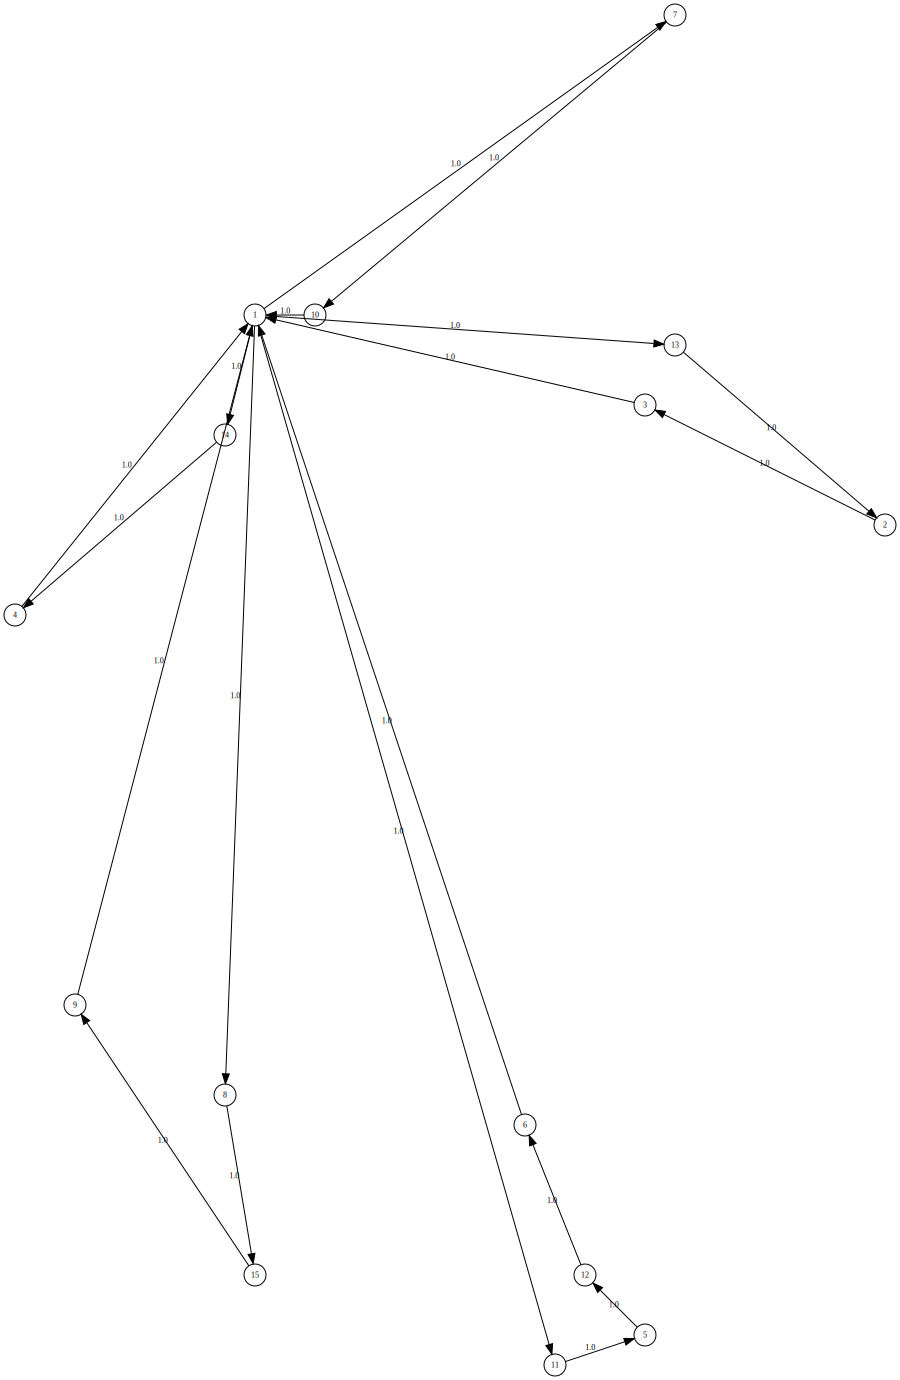

In [18]:
display(SVG(filename=basename+'_sol.svg'))
